<a href="https://colab.research.google.com/github/dhyannn/reinforcment-learing/blob/main/514_RLlab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install gym

In [ ]:
import gym
import numpy as np
from collections import defaultdict

# Create Blackjack environment
env = gym.make('Blackjack-v1')

def generate_episode(policy, env):
    """
    Generates an episode following a given policy.
    Args:
        policy: A dictionary mapping states to action probabilities.
        env: The environment.
    Returns:
        A list of (state, action, reward) tuples.
    """
    episode = []
    state = env.reset()
    while True:
        action = np.random.choice([0, 1], p=policy[state])
        next_state, reward, done, _ = env.step(action)
        episode.append((state, action, reward))
        if done:
            break
        state = next_state
    return episode

def first_visit_mc_prediction(env, policy, episodes=5000):
    """
    Estimates the state-value function using First-Visit Monte Carlo Prediction.
    Args:
        env: The environment.
        policy: A dictionary mapping states to action probabilities.
        episodes: Number of episodes to generate.
    Returns:
        A dictionary mapping states to value estimates.
    """
    returns_sum = defaultdict(float)
    returns_count = defaultdict(int)
    V = defaultdict(float)

    for _ in range(episodes):
        episode = generate_episode(policy, env)
        visited_states = set()
        G = 0
        for t in reversed(range(len(episode))):
            state, _, reward = episode[t]
            G += reward
            if state not in visited_states:
                returns_sum[state] += G
                returns_count[state] += 1
                V[state] = returns_sum[state] / returns_count[state]
                visited_states.add(state)
    return V

def monte_carlo_control_epsilon_greedy(env, episodes=5000, epsilon=0.1):
    """
    Finds the optimal policy using Monte Carlo Control with an epsilon-greedy strategy.
    Args:
        env: The environment.
        episodes: Number of episodes to generate.
        epsilon: Probability of choosing a random action.
    Returns:
        A dictionary representing the optimal policy and the state-action value function.
    """
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    returns_sum = defaultdict(float)
    returns_count = defaultdict(int)

    def epsilon_greedy_policy(state):
        """
        Epsilon-greedy policy derived from the Q-function.
        """
        if state in Q:
            A = np.ones(env.action_space.n) * epsilon / env.action_space.n
            best_action = np.argmax(Q[state])
            A[best_action] += (1.0 - epsilon)
            return A
        else:
            return np.ones(env.action_space.n) / env.action_space.n

    for _ in range(episodes):
        episode = []
        state = env.reset()
        while True:
            action_probs = epsilon_greedy_policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        G = 0
        visited_state_actions = set()
        for t in reversed(range(len(episode))):
            state, action, reward = episode[t]
            G += reward
            if (state, action) not in visited_state_actions:
                returns_sum[(state, action)] += G
                returns_count[(state, action)] += 1
                Q[state][action] = returns_sum[(state, action)] / returns_count[(state, action)]
                visited_state_actions.add((state, action))

    policy = {state: np.eye(env.action_space.n)[np.argmax(actions)] for state, actions in Q.items()}
    return policy, Q

# Running the model-free prediction and control
random_policy = defaultdict(lambda: np.ones(env.action_space.n) / env.action_space.n)
state_values = first_visit_mc_prediction(env, random_policy, episodes=5000)
optimal_policy, optimal_Q = monte_carlo_control_epsilon_greedy(env, episodes=5000)

# Displaying results
print("State-Value Function (V):")
for state, value in list(state_values.items())[:5]:  # Display only the first 5 states for brevity
    print(f"State: {state}, Value: {value}")

print("\nOptimal Policy:")
for state, actions in list(optimal_policy.items())[:5]:  # Display only the first 5 states for brevity
    print(f"State: {state}, Action Probabilities: {actions}")


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


State-Value Function (V):
State: (19, 1, False), Value: -0.625
State: (10, 2, False), Value: -0.5
State: (20, 10, False), Value: -0.29523809523809524
State: (17, 10, False), Value: -0.7272727272727273
State: (21, 10, True), Value: 0.3924050632911392

Optimal Policy:
State: (12, 3, False), Action Probabilities: [0. 1.]
State: (16, 8, False), Action Probabilities: [0. 1.]
State: (14, 3, False), Action Probabilities: [1. 0.]
State: (7, 3, False), Action Probabilities: [0. 1.]
State: (20, 2, False), Action Probabilities: [1. 0.]


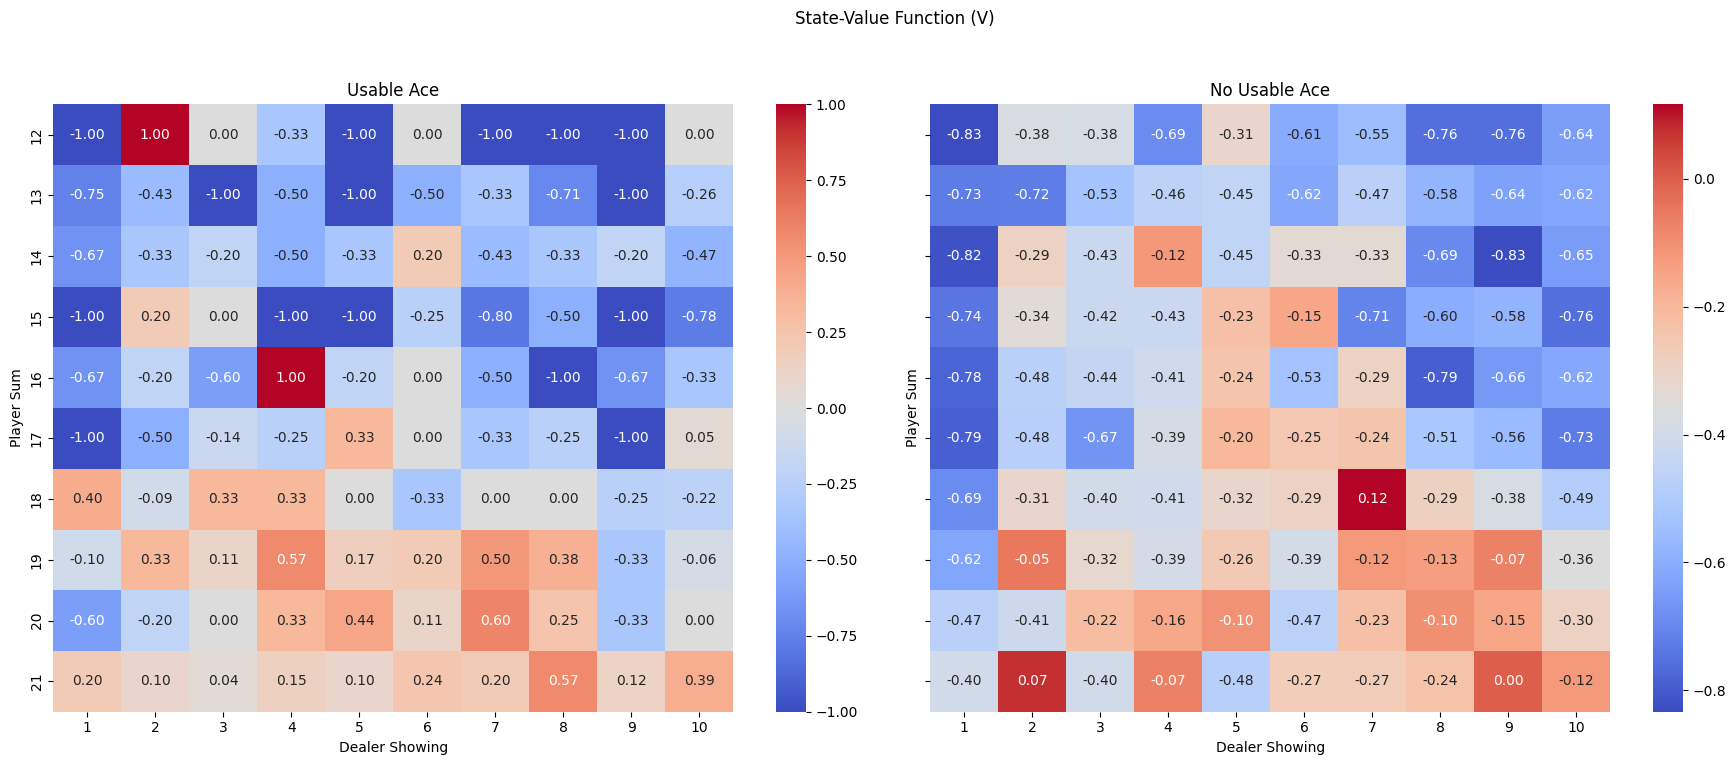

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_state_values(V):
    """
    Plots the state-value function for blackjack.
    Args:
        V: State-value function as a dictionary.
    """
    # Prepare data for plotting
    player_sums = range(12, 22)  # Player's hand value (12 to 21)
    dealer_shows = range(1, 11)  # Dealer's face-up card (1 to 10)
    usable_ace = [True, False]

    fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=True)
    fig.suptitle("State-Value Function (V)")

    for i, ace in enumerate(usable_ace):
        values = np.zeros((len(player_sums), len(dealer_shows)))
        for p_idx, player in enumerate(player_sums):
            for d_idx, dealer in enumerate(dealer_shows):
                state = (player, dealer, ace)
                values[p_idx, d_idx] = V.get(state, 0)  # Default to 0 if state is not in V

        ax = axes[i]
        sns.heatmap(values, annot=True, fmt=".2f", xticklabels=dealer_shows,
                    yticklabels=player_sums, cmap="coolwarm", ax=ax)
        ax.set_title("Usable Ace" if ace else "No Usable Ace")
        ax.set_xlabel("Dealer Showing")
        ax.set_ylabel("Player Sum")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Visualize the state-value function
plot_state_values(state_values)
